In [31]:
import sys
import os
import distutils.core
import torch
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
import json
#!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
# import some common detectron2 utilities
import detectron2
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer

from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import random
import cv2 

In [32]:
setup_logger()

<Logger detectron2 (DEBUG)>

In [33]:
#load dataset
annotations_path = "./annotations/instances_val2017.json"
database_path = "./val2017/"
coco_annotation=COCO(annotations_path)
 
 

loading annotations into memory...
Done (t=1.20s)
creating index...
index created!


ANNOTATION [{'segmentation': [[216.81, 9.58, 225.44, 13.9, 237.3, 21.45, 243.78, 21.45, 250.25, 49.49, 267.51, 59.2, 284.76, 87.24, 292.31, 91.56, 285.84, 120.68, 285.84, 133.63, 273.98, 139.02, 276.13, 145.49, 258.88, 172.46, 263.19, 179.27, 261.03, 205.9, 266.43, 218.84, 276.13, 239.33, 298.79, 245.81, 310.65, 240.41, 307.42, 225.31, 302.02, 203.74, 310.65, 191.87, 318.2, 168.14, 333.3, 153.04, 325.75, 189.72, 319.28, 231.78, 304.69, 286.9, 382.92, 298.66, 379.69, 286.8, 373.21, 286.8, 358.11, 285.72, 351.64, 278.17, 370.95, 215.59, 387.24, 182.17, 393.94, 159.62, 395.87, 137.94, 400.18, 127.16, 394.79, 53.81, 395.87, 39.78, 382.92, 13.9, 381.84, 2.03, 381.84, 2.03, 211.42, 2.03, 220.04, 9.58], [413.12, 2.03, 407.04, 13.55, 406.68, 35.85, 412.42, 41.23, 404.17, 41.94, 408.46, 52.73, 414.19, 51.27, 430.74, 48.78, 433.62, 36.55, 432.54, 19.29, 429.3, 13.9, 425.0, 0.61, 414.91, 0.0]], 'area': 32042.990900000008, 'iscrowd': 0, 'image_id': 112110, 'bbox': [211.42, 0.0, 222.2, 298.66], 'ca

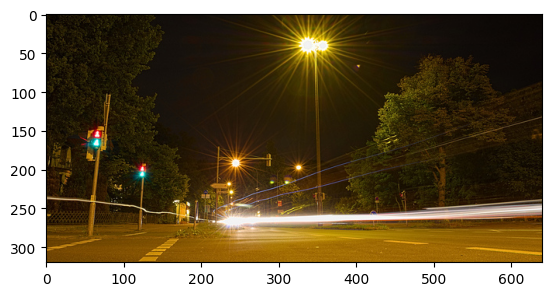

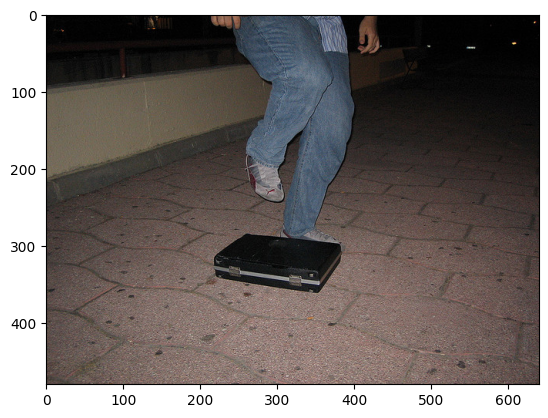

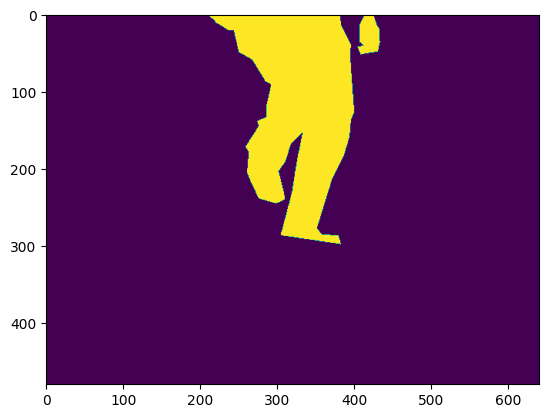

In [34]:

# Get list of category_ids, here [2] for bicycle


img1_filename = random.choice(os.listdir(database_path)) #change dir name to whatever
img2_filename = random.choice(os.listdir(database_path)) #change dir name to whatever
img1 = cv2.imread(database_path+img1_filename)
img2 = cv2.imread(database_path+img2_filename)
img1_id = int(img2_filename.split('.')[0])
img2_id = int(img2_filename.split('.')[0])

img1_info = coco_annotation.loadImgs([img1_id])[0]
img1_height = img1_info["height"]
img1_width = img1_info["width"]

random_annotation_ids = coco_annotation.getAnnIds(imgIds=img2_id)
random_annotation_id = random_annotation_ids[random.randint(0, len(random_annotation_ids)-1)]   #pick 1
random_annotation_img2  = coco_annotation.loadAnns(random_annotation_id)
random_mask_img2 = coco_annotation.annToMask(random_annotation_img2[0])

plt.figure()
plt.imshow(img1[:,:,::-1])
plt.figure()
plt.imshow(img2[:,:,::-1])
plt.figure()
plt.imshow(random_mask_img2)

print("ANNOTATION" ,random_annotation_img2)
print(len(random_annotation_ids))

print("Image 1 (target): ",img1_filename)
print("Image 2 (source): ",img2_filename)

print("IMG 1 info ", img1_height)
im = img1.copy()


In [35]:
def pad_image(img, new_image_height, new_image_width):
    
    color = (0,0,0)
    if len(img.shape)==3:
        old_image_height, old_image_width, channels = img.shape
        
        result = np.full((new_image_height,new_image_width, channels), color, dtype=np.uint8)
    if len(img.shape)==2:
        old_image_height, old_image_width = img.shape
        result = np.full((new_image_height,new_image_width), 0, dtype=np.uint8)


    # compute center offset
    x_center = (new_image_width - old_image_width) // 2
    y_center = (new_image_height - old_image_height) // 2

    # copy img image into center of result image
    result[y_center:y_center+old_image_height, 
        x_center:x_center+old_image_width] = img
    return result
def transplant_images(image_1, image_2,image_2_mask):

    image_1_copy = image_1.copy() 

    #--- Copy pixel values of logo image to room image wherever the mask is white ---
    image_1_copy[np.where(image_2_mask == 1)] = image_2[np.where(image_2_mask == 1)]

    return image_1_copy



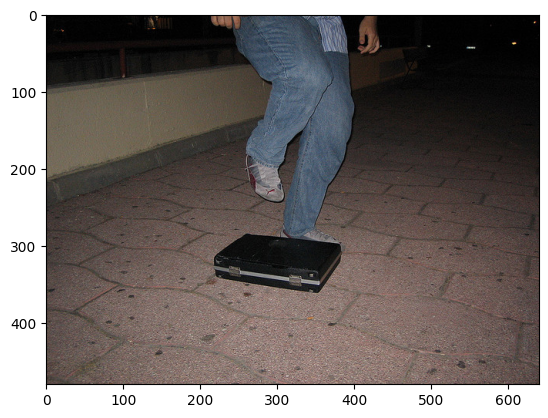

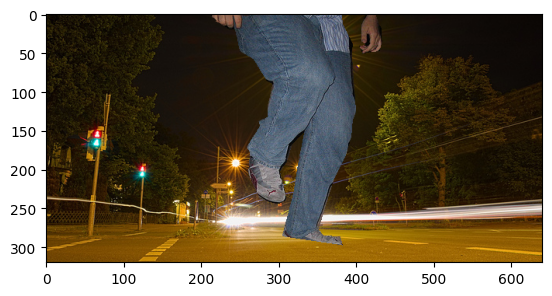

In [36]:
padded_image =  pad_image(img2,img1_height, img1_width)
padded_mask_2 =  pad_image(random_mask_img2,img1_height, img1_width)
plt.figure()
plt.imshow(padded_image[:,:,::-1])
new_image =  transplant_images(img1, padded_image,padded_mask_2)

plt.figure()
plt.imshow(new_image[:,:,::-1])


In [37]:
cfg = get_cfg()
model = 'mask_rcnn'
if model == 'mask_rcnn':
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
elif model == 'fast_rcnn':
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.DEVICE='cpu'
predictor = DefaultPredictor(cfg)

[03/22 23:19:38 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


In [38]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
outputs = predictor(img1)
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

outputs_transplant = predictor(new_image)
print(outputs_transplant["instances"].pred_classes)
print(outputs_transplant["instances"].pred_boxes)

tensor([9, 9, 9, 9, 9, 9, 9])
Boxes(tensor([[283.4954, 180.8841, 290.9732, 197.5918],
        [ 58.4012, 149.6854,  72.2490, 175.5474],
        [119.6278, 194.6047, 128.9010, 212.4717],
        [456.4844, 229.3899, 460.7416, 236.9865],
        [344.4149, 231.5106, 348.6517, 239.7381],
        [355.5016, 230.9570, 360.4710, 239.9777],
        [287.9432, 213.9564, 295.2599, 221.2416]]))
tensor([0, 9, 9, 0, 9])
Boxes(tensor([[217.7537,   0.0000, 416.0927, 302.8699],
        [ 58.4012, 149.6854,  72.2490, 175.5474],
        [119.6278, 194.6047, 128.9010, 212.4717],
        [404.6208,   0.6612, 433.7229,  52.2125],
        [456.4835, 229.4051, 460.7326, 236.9916]]))


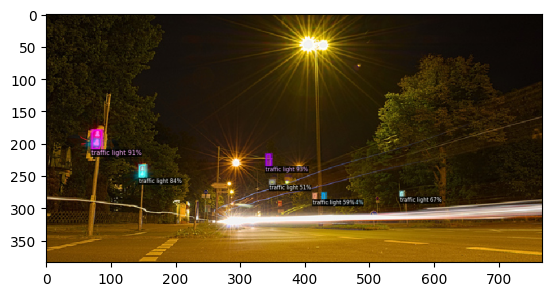

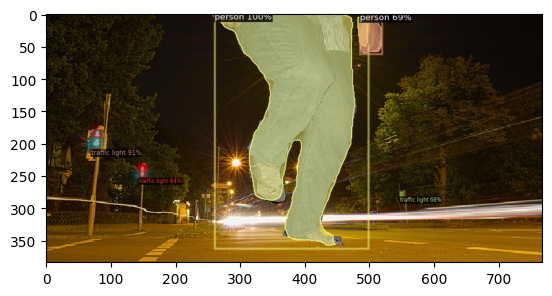

In [39]:
# We can use `Visualizer` to draw the predictions on the image.

v = Visualizer(img1[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

plt.figure()
plt.imshow(out.get_image())


v_transplant = Visualizer(new_image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out_transplant = v_transplant.draw_instance_predictions(outputs_transplant["instances"].to("cpu"))
plt.figure()
plt.imshow(out_transplant.get_image())